In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install shap

In [6]:
!pip install 'tensorflow==1.14.0'
!pip install keras==2.3.1

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [8]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import GRU
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
plt.rc('font', family='NanumBarunGothic') #set font
plt.rc('axes', unicode_minus=False)

# Data Road

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/TestData.csv')
print(df.shape)
df

(43771, 14)


,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일사,전운량,시정,PM10,월
0,전남 목포시,9,20.160,2013-01-01,2.6,6.0,290.0,91.0,1019.6,0.03,10.0,1300.0,43.0,1
1,전남 목포시,10,106.800,2013-01-01,4.2,5.8,250.0,82.0,1019.9,0.57,7.0,1300.0,56.0,1
2,전남 목포시,11,469.560,2013-01-01,3.8,7.1,320.0,80.0,1020.5,1.00,9.0,1300.0,75.0,1
3,전남 목포시,12,504.240,2013-01-01,4.9,2.8,290.0,73.0,1020.1,1.05,7.0,1300.0,84.0,1
4,전남 목포시,13,745.200,2013-01-01,5.2,6.7,320.0,66.0,1019.7,1.14,6.0,1100.0,78.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43766,강원 강릉시,13,35.328,2020-12-31,-1.1,3.2,200.0,24.0,1020.1,1.94,0.0,5000.0,13.0,12
43767,강원 강릉시,14,36.864,2020-12-31,0.0,2.6,360.0,22.0,1019.5,1.80,0.0,5000.0,11.0,12
43768,강원 강릉시,15,401.280,2020-12-31,0.3,4.5,230.0,27.0,1019.1,1.47,0.0,5000.0,16.0,12
43769,강원 강릉시,16,382.464,2020-12-31,-0.1,4.0,230.0,29.0,1019.2,0.94,0.0,5000.0,13.0,12


In [ ]:
area_name = ['Gn', 'Jj', 'Mp' ] 
for idx, area in enumerate(['강원 강릉시','경남 진주시', '전남 목포시']): #지역별로 데이터 분리
  name = area_name[idx]
  data = df[df['지역'] == area]
  data.reset_index(drop=True, inplace=True)
  globals()[f'{name}_df'] = data
print(f'전체데이터: {df.shape},\n목포시 : {Mp_df.shape},\n강릉시 : {Gn_df.shape},\n진주시 : {Jj_df.shape}')

전체데이터: (43771, 14),
목포시 : (26389, 14),
강릉시 : (8908, 14),
진주시 : (8474, 14)


#Train, Test split

In [ ]:
# Train Set의 편차열 생성 함수
def deviation(data, cols): 
  df = data.copy()
  cols.extend(['월','시간']) # 평균 계산할때 기준
  #변수 별로 월, 시간 평균 계산
  mean_df = pd.DataFrame() # 평균 계산한 df
  for m in df['월'].unique():
    for h in df['시간'].unique():
      mn = np.array(df[(df['월'] == m) & (df['시간'] == h)][cols].mean())
      mean_data = pd.DataFrame([mn], columns = cols)
      mean_df = pd.concat([mean_df, mean_data])

  mean_df.dropna(how='any', inplace=True)
  mean_df.reset_index(inplace=True, drop=True)
  mean_df[['시간','월']] = mean_df[['시간','월']].astype(int)

  # 기존 값 - 평균 =  변수들의 편차
  del cols[-2:] # 추가한 평균, 월을 제외한 나머지 편차 생성
  dev_df = pd.DataFrame(0, index = df.index, columns = cols) # 편차 df

  hours = mean_df['시간'].unique()
  months = mean_df['월'].unique()
  for m, h in [(x,y) for x in months for y in hours]:
    idx = df[(df['월'] == m) & (df['시간'] == h)].index
    m_idx = mean_df[(mean_df['월'] == m) & (mean_df['시간'] == h)].index
    dev_df.loc[idx, cols] = df.loc[idx, cols] - mean_df.loc[m_idx, cols].squeeze()

  # 편차 df 변수 이름 변경
  rename_c = [i+'편차' for i in dev_df.columns]
  dev_df.columns = rename_c

  return mean_df, dev_df

In [ ]:
# RNN모델에 사용하기 위해 차원 셋으로 만드는 함수
# t일의 태양광값을 계산하기 위해 (t-20,t-19,t-18...) 20일간의 X데이터를 이용.
def make_data(X_Data,Y_Data, sequence):
  feature_list = []
  target_list = []
  for i in range(len(X_Data)-sequence):
    X = np.array(X_Data.iloc[i:i+sequence])
    Y = np.array(Y_Data.iloc[i+sequence])
    feature_list.append(X)
    target_list.append(Y)
  return np.array(feature_list), np.array(target_list)

In [ ]:
# train, test_set 생성함수

def MakeDataSet(df, area, cols, target): 
   # 마지막 년도 test로 사용
  test_year = df['일자'].str[:4].unique().max()
  last_year = df[df['일자'] >= f'{test_year}-01-01'].index[0]
  train = df[df.index < last_year]  
  test = df[df.index >= last_year]

  feature_cols = [x for x in cols if x not in ['발전량']]
  if target == '발전량편차':
    feature_train = [x+'편차' for x in feature_cols]
    #train set 편차열 생성
    mean_train, dev_df = deviation(train, cols)
    x_train = dev_df[feature_train]
    y_train = dev_df[[target]]

    #train-set에서 계산된 발전량 평균값을 학습 후 test-set 예측에 사용
    mn_df = pd.merge(test[['월','시간','발전량']], mean_train[['월','시간','발전량']], on=['월','시간'], how='left')
    mn_df.rename(columns ={'발전량_y':'발전량평균'}, inplace=True)
    testmn = mn_df[['발전량평균']]
    testmn = testmn.fillna(0)

    # test-set 편차열 생성
    mean_test, dev_df = deviation(test, cols)
    x_test = dev_df[feature_train]
  else:
    x_train = train[feature_cols]
    y_train = train[['발전량']]
    x_test = test[feature_cols]

  # 편차, 기존 변수 학습후에도 test target은 발전량
  y_test = test[['발전량']]

  #분리된 x_set 정규화
  sc = MinMaxScaler() 
  train_sc = sc.fit_transform(x_train)
  test_sc = sc.transform(x_test)
  train_sc_df = pd.DataFrame(train_sc, columns=feature_cols, index=x_train.index)
  test_sc_df = pd.DataFrame(test_sc, columns=feature_cols, index=x_test.index)

  train_X, train_Y = make_data(train_sc_df, y_train, 20) # 차원 만들기
  test_X, test_Y = make_data(test_sc_df, y_test, 20)
  if target == '발전량편차':
    t, testmn = make_data(test_sc_df, testmn, 20)
  else:
    testmn = None

  print(f'{area} : ',train_X.shape, train_Y.shape, test_X.shape, test_Y.shape) # 샘플 수, 타임스텝 수, 속성 수
  print('Train-set: ', ', '.join(x_train.columns), y_train.columns,'\nTest-set : ', ', '.join(x_test.columns), y_test.columns) #선택된 변수
  return testmn, train_X ,train_Y ,test_X ,test_Y 

In [ ]:
cols = [x for x in df.columns if x not in ['일자','지역','월','시간']]
cols

['발전량', '기온', '풍속', '풍향', '습도', '해면기압', '일사', '전운량', '시정', 'PM10']

In [ ]:
testmn, train_x ,train_y ,test_x ,test_y = MakeDataSet(Jj_df, '진주시', cols, '발전량')

진주시 :  (5815, 20, 9) (5815, 1) (2619, 20, 9) (2619, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


In [ ]:
testmn, train_x ,train_y ,test_x ,test_y = MakeDataSet(Gn_df, '강릉시', cols, '발전량')

강릉시 :  (5021, 20, 9) (5021, 1) (3847, 20, 9) (3847, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


In [ ]:
testmn, train_x ,train_y ,test_x ,test_y = MakeDataSet(Mp_df, '목포시', cols, '발전량편차')

목포시 :  (22044, 20, 9) (22044, 1) (4305, 20, 9) (4305, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


In [ ]:
testmn, train_x ,train_y ,test_x ,test_y = MakeDataSet(Jj_df, '진주시', cols, '발전량편차')

진주시 :  (5815, 20, 9) (5815, 1) (2619, 20, 9) (2619, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


#  RNN Model Learning

## LSTM

In [ ]:
RMSE = {} #score점수를 저장 
R2 = {}

In [ ]:
#LSTM 생성
LSTM_model = Sequential() 
LSTM_model.add(LSTM(16, activation = 'tanh', input_shape=(20,9), return_sequences = True)) #input_shape=(타임스텝수, 속성 수)
LSTM_model.add(LSTM(16, activation = 'tanh'))
LSTM_model.add(Dense(4))
LSTM_model.add(Dense(1))
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 16)            1664      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 3,849
Trainable params: 3,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
 # 모델 학습 후 shap 생성 함수
def ShapPlot(model, train_X, model_name, area_name, cols):
  tf.keras.backend.get_session(
    op_input_list=())
  explainer = shap.GradientExplainer(model = model, data = train_X)
  shap_values = explainer.shap_values(train_X)

  shap_values_2D = shap_values[0].reshape(-1,9)
  X_train_2D = train_X.reshape(-1,9)

  plt.title(f"{area_name} {model_name} Shap barplot", fontsize=15, pad=10)
  shap.summary_plot(shap_values_2D, X_train_2D, cols, plot_type='bar')
  plt.show()
  plt.title(f"{area_name} {model_name} Shap plot", fontsize=15, pad=10)
  shap.summary_plot(shap_values_2D, X_train_2D, cols)
  plt.show()

In [ ]:
#모델 학습과정 표시
def loss_plot(hist, model_name):
  fig, loss_ax = plt.subplots(figsize=(12,4))
  plt.title(f"{model_name} loss plot", fontsize=15, pad=15)
  loss_ax.plot(h.history['loss'], 'y', label = 'train loss')
  loss_ax.plot(h.history['val_loss'], 'r', label = 'val loss')
  loss_ax.set_xlabel('epoch', fontsize=13)
  loss_ax.set_ylabel('loss', fontsize=13)
  loss_ax.legend(loc = 'upper left', fontsize=15)
  plt.show()

In [ ]:
# RNN 최종 학습 함수
def Model_RNN(df, model, area, area_name, cols, target):
  # target에 맞춰 편차 or 일반 변수가 train set 으로 생성
  # test를 통한 성능 비교는 동일하게 일반 변수
  testmn, train_x ,train_y ,test_x ,test_y  = MakeDataSet(df, area, cols, target)

  #tf 초기화
  init_op = tf.global_variables_initializer()
  sess = tf.compat.v1.Session()
  sess.run(init_op)

  # 모델 학습 
  if model == 'LSTM':
    m = LSTM_model
  elif model == 'GRU':
    m = GRU_model  
  m.compile(optimizer='adam', loss='mean_squared_error')
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  h = m.fit(train_x, train_y, epochs=100, batch_size=5, validation_split=0.2, callbacks=[es], verbose=0)

  # test
  y_pred = m.predict(test_x)
  if target == '발전량편차':
    y_pred = y_pred + testmn #예측편차 + 평균값
    # score 저장 
    R2_score = r2_score(y_pred, test_y)
    RMSE_score = sqrt(mean_squared_error(y_pred, test_y))
    R2[f'Dev_{model}_{area}'] = R2_score
    RMSE[f'Dev_{model}_{area}'] = RMSE_score
  else:
    # score 저장
    R2_score = r2_score(y_pred, test_y)
    RMSE_score = sqrt(mean_squared_error(y_pred, test_y))
    R2[f'{model}_{area}'] = R2_score
    RMSE[f'{model}_{area}'] = RMSE_score

  return y_pred, test_y, h, m, train_x

In [ ]:
feature_ori = [x for x in cols if x not in ['발전량']]
feature_dev = [x+'편차' for x in cols if x not in ['발전량']]
feature_ori, feature_dev

(['기온', '풍속', '풍향', '습도', '해면기압', '일사', '전운량', '시정', 'PM10'],
 ['기온편차', '풍속편차', '풍향편차', '습도편차', '해면기압편차', '일사편차', '전운량편차', '시정편차', 'PM10편차'])

Mp :  (22044, 20, 9) (22044, 1) (4305, 20, 9) (4305, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')
Epoch 00028: early stopping


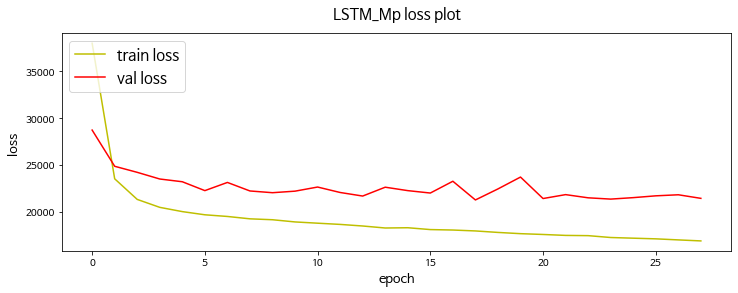

In [ ]:
y_pred, test_y, h, model_LSTM, train_X = Model_RNN(Mp_df, 'LSTM', 'Mp', '목포시', cols, '발전량편차')
loss_plot(h,'LSTM_Mp')

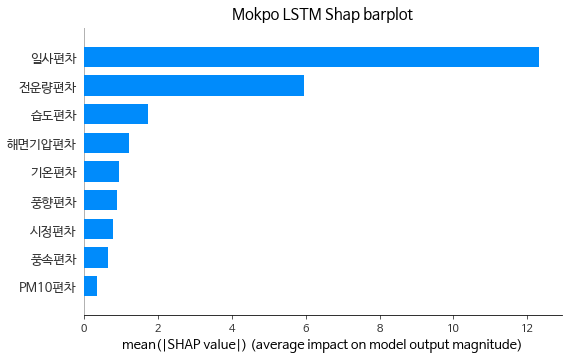

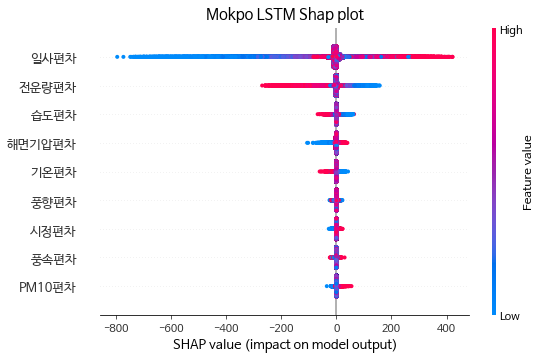

In [ ]:
ShapPlot(model_LSTM, train_X, 'LSTM', 'Mokpo', feature_dev)

Mp :  (22044, 20, 9) (22044, 1) (4305, 20, 9) (4305, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')
Epoch 00026: early stopping


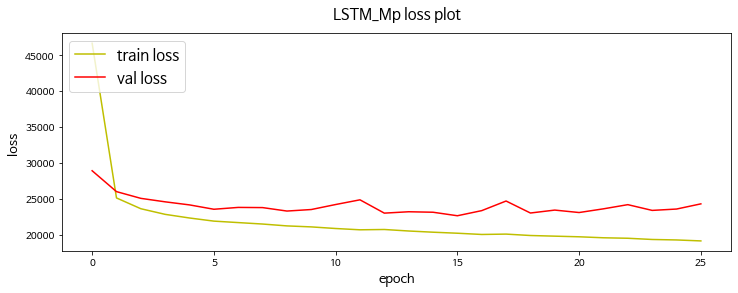

In [ ]:
y_pred, test_y, h, model_LSTM, train_X = Model_RNN(Mp_df, 'LSTM', 'Mp', '목포시', cols, '발전량')
loss_plot(h,'LSTM_Mp')

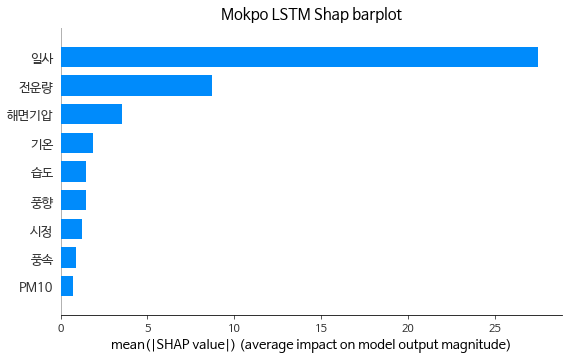

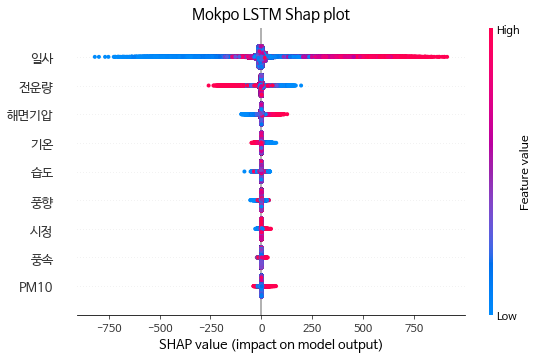

In [ ]:
ShapPlot(model_LSTM, train_X, 'LSTM', 'Mokpo', feature_ori)

Jj :  (5815, 20, 9) (5815, 1) (2619, 20, 9) (2619, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')
Epoch 00021: early stopping


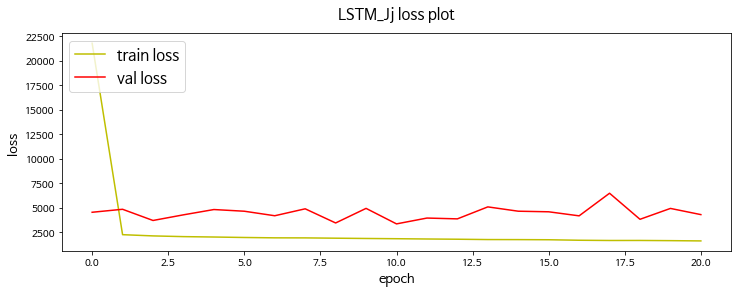

In [ ]:
y_pred, test_y, h, model_LSTM, train_X = Model_RNN(Jj_df, 'LSTM', 'Jj', '진주시', cols, '발전량편차')
loss_plot(h,'LSTM_Jj')

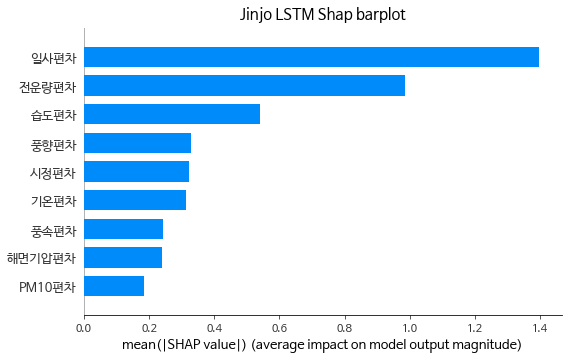

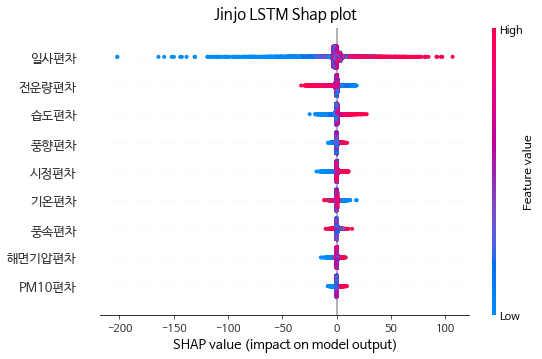

In [ ]:
ShapPlot(model_LSTM, train_X, 'LSTM', 'Jinjo', feature_dev)

Jj :  (5815, 20, 9) (5815, 1) (2619, 20, 9) (2619, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')
Epoch 00012: early stopping


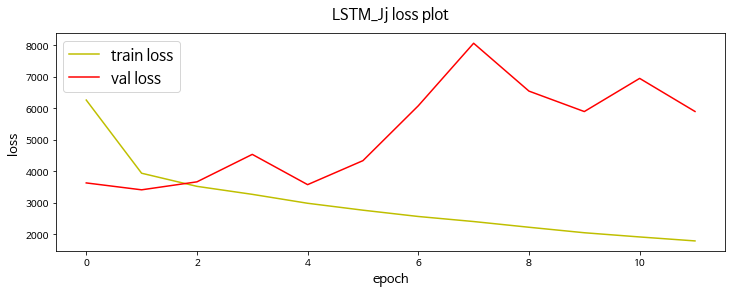

In [ ]:
y_pred, test_y, h, model_LSTM, train_X = Model_RNN(Jj_df, 'LSTM', 'Jj', '진주시', cols, '발전량')
loss_plot(h,'LSTM_Jj')

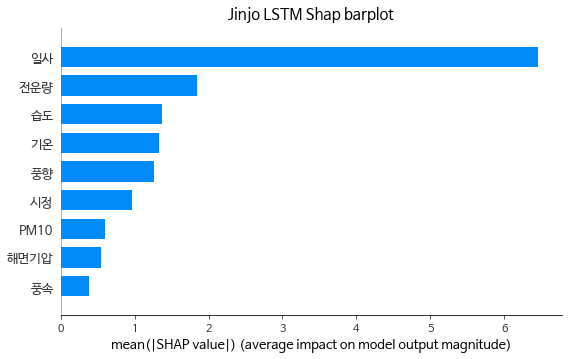

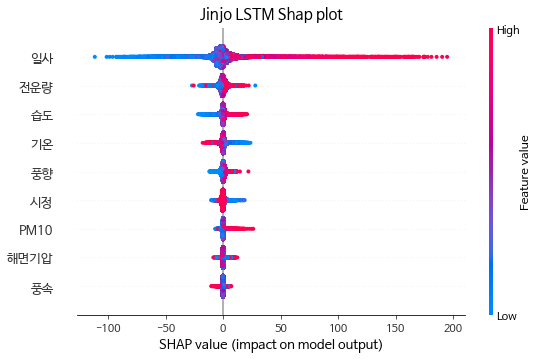

In [ ]:
ShapPlot(model_LSTM, train_X, 'LSTM', 'Jinjo', feature_ori)

Gn :  (5021, 20, 9) (5021, 1) (3847, 20, 9) (3847, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')
Epoch 00020: early stopping


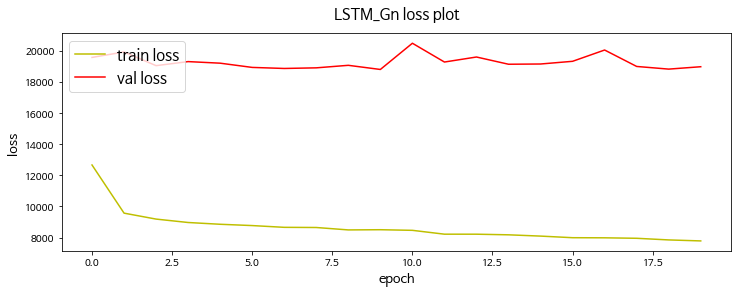

In [ ]:
y_pred, test_y, h, model_LSTM, train_X = Model_RNN(Gn_df, 'LSTM', 'Gn', '강릉시', cols, '발전량편차')
loss_plot(h,'LSTM_Gn')

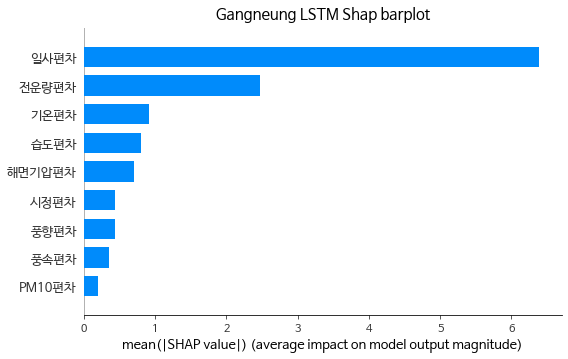

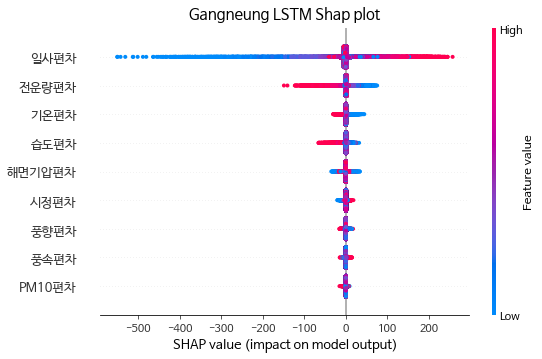

In [ ]:
ShapPlot(model_LSTM, train_X, 'LSTM', 'Gangneung', feature_dev)

Gn :  (5021, 20, 9) (5021, 1) (3847, 20, 9) (3847, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')
Epoch 00017: early stopping


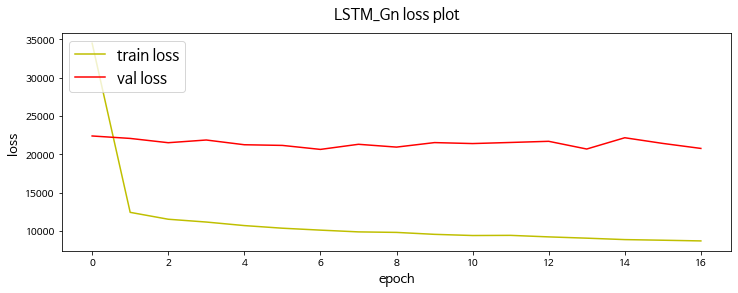

In [ ]:
y_pred, test_y, h, model_LSTM, train_X = Model_RNN(Gn_df, 'LSTM', 'Gn', '강릉시', cols, '발전량')
loss_plot(h,'LSTM_Gn')

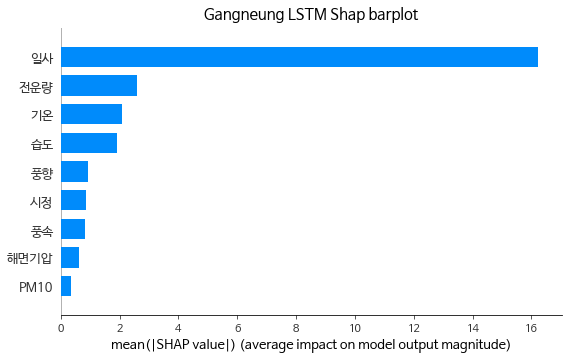

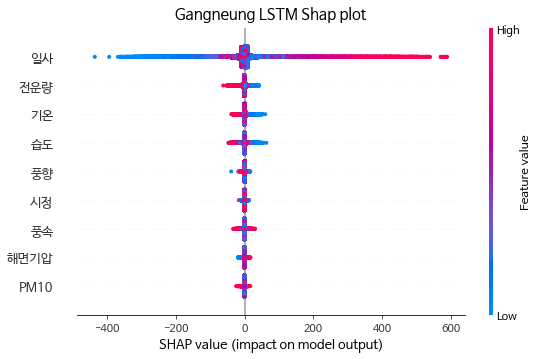

In [ ]:
ShapPlot(model_LSTM, train_X, 'LSTM', 'Gangneung', feature_ori)

## GRU

In [ ]:
GRU_model = Sequential()
GRU_model.add(GRU(16, activation = 'tanh', input_shape=(20,9), return_sequences = True)) #input_shape=(타임스텝수, 속성 수)
GRU_model.add(GRU(16, activation = 'tanh'))
GRU_model.add(Dense(4))
GRU_model.add(Dense(1))
GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 20, 16)            1248      
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                1584      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 2,905
Trainable params: 2,905
Non-trainable params: 0
_________________________________________________________________


Mp :  (22044, 20, 9) (22044, 1) (4305, 20, 9) (4305, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')
Epoch 00037: early stopping


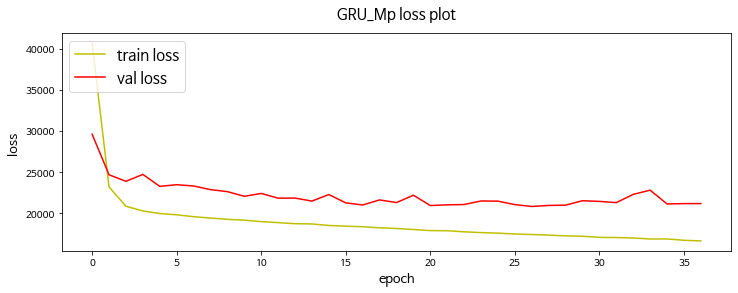

In [ ]:
y_pred, test_y, h, model_GRU, train_X = Model_RNN(Mp_df, 'GRU', 'Mp', '목포시', cols, '발전량편차')
loss_plot(h,'GRU_Mp')

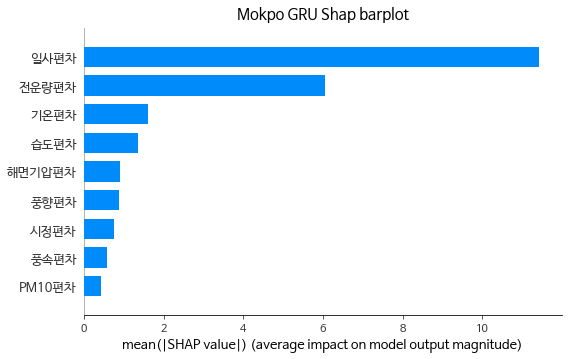

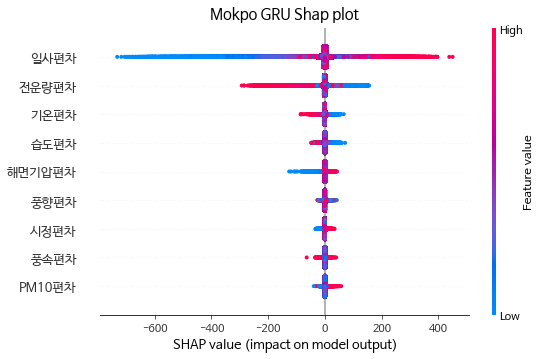

In [ ]:
ShapPlot(model_GRU, train_X, 'GRU', 'Mokpo', feature_dev)

Mp :  (22044, 20, 9) (22044, 1) (4305, 20, 9) (4305, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')
Epoch 00024: early stopping


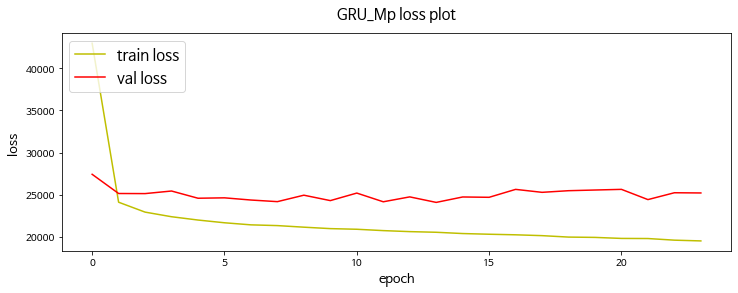

In [ ]:
y_pred, test_y, h, model_GRU, train_X = Model_RNN(Mp_df, 'GRU', 'Mp', '목포시', cols, '발전량')
loss_plot(h,'GRU_Mp')

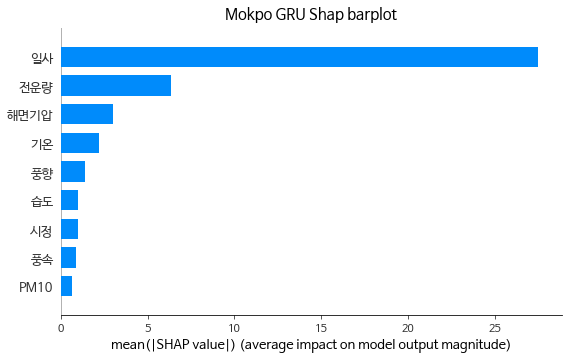

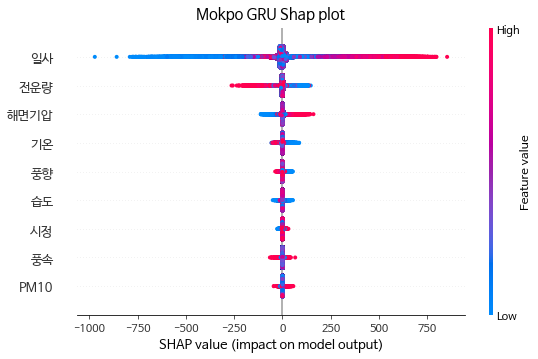

In [ ]:
ShapPlot(model_GRU, train_X, 'GRU', 'Mokpo', feature_ori)

Jj :  (5815, 20, 9) (5815, 1) (2619, 20, 9) (2619, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')
Epoch 00013: early stopping


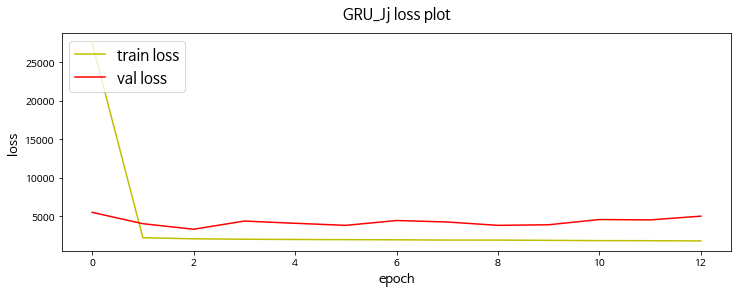

In [ ]:
y_pred, test_y, h, model_GRU, train_X = Model_RNN(Jj_df, 'GRU', 'Jj', '진주시', cols, '발전량편차')
loss_plot(h,'GRU_Jj')

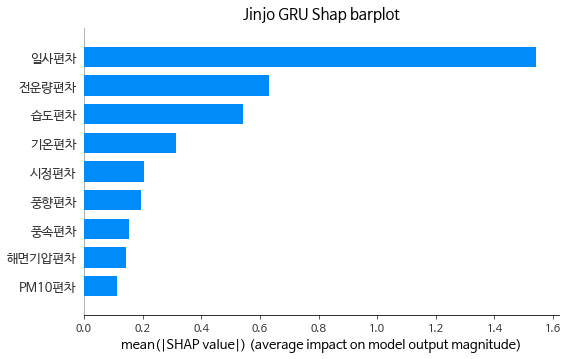

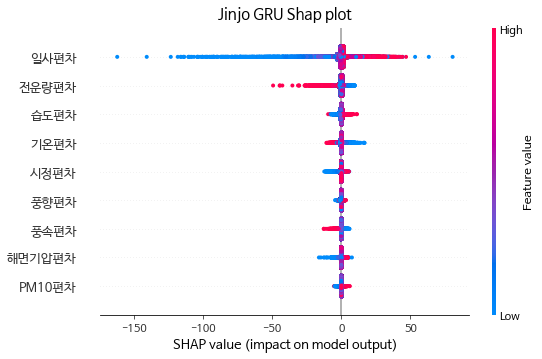

In [ ]:
ShapPlot(model_GRU, train_X, 'GRU', 'Jinjo', feature_dev)

Jj :  (5815, 20, 9) (5815, 1) (2619, 20, 9) (2619, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')
Epoch 00011: early stopping


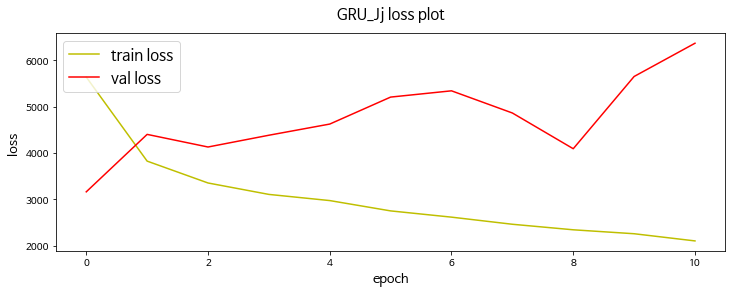

In [ ]:
y_pred, test_y, h, model_GRU, train_X = Model_RNN(Jj_df, 'GRU', 'Jj', '진주시', cols, '발전량')
loss_plot(h,'GRU_Jj')

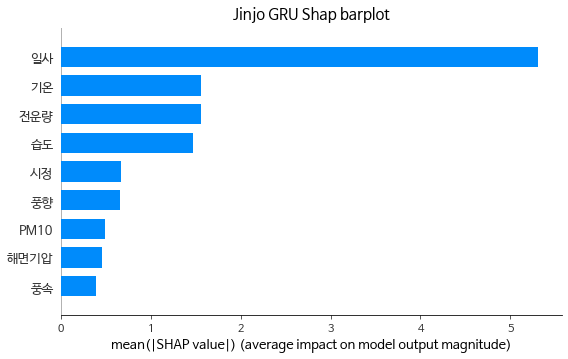

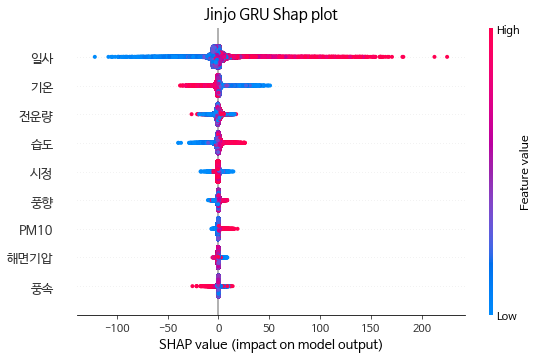

In [ ]:
ShapPlot(model_GRU, train_X, 'GRU', 'Jinjo', feature_ori)

Gn :  (5021, 20, 9) (5021, 1) (3847, 20, 9) (3847, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')
Epoch 00028: early stopping


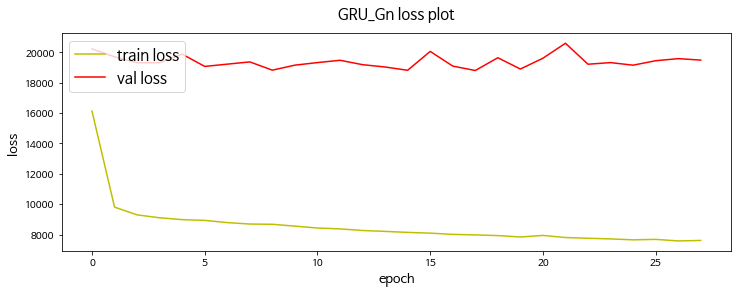

In [ ]:
y_pred, test_y, h, model_GRU, train_X = Model_RNN(Gn_df, 'GRU', 'Gn', '강릉시', cols, '발전량편차')
loss_plot(h,'GRU_Gn')

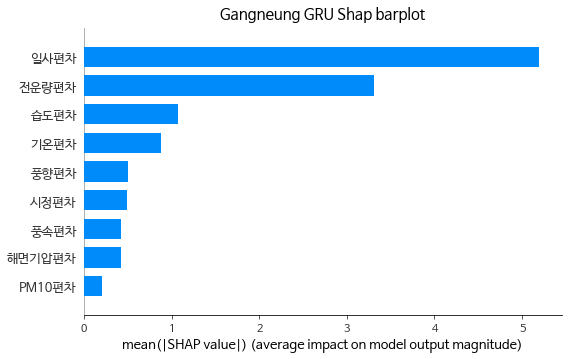

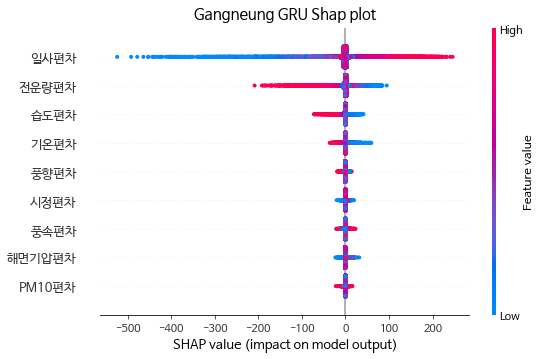

In [ ]:
ShapPlot(model_GRU, train_X, 'GRU', 'Gangneung', feature_dev)

Gn :  (5021, 20, 9) (5021, 1) (3847, 20, 9) (3847, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')
Epoch 00031: early stopping


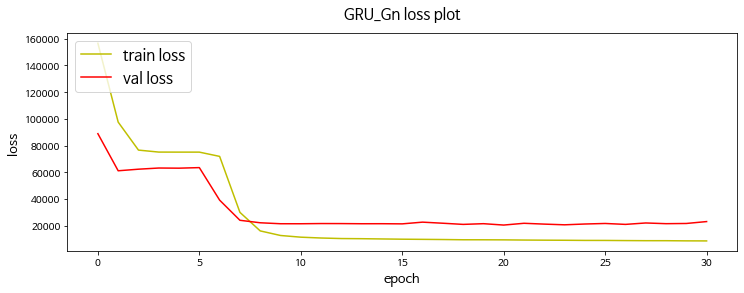

In [ ]:
y_pred, test_y, h, model_GRU, train_X = Model_RNN(Gn_df, 'GRU', 'Gn', '강릉시', cols, '발전량')
loss_plot(h,'GRU_Gn')

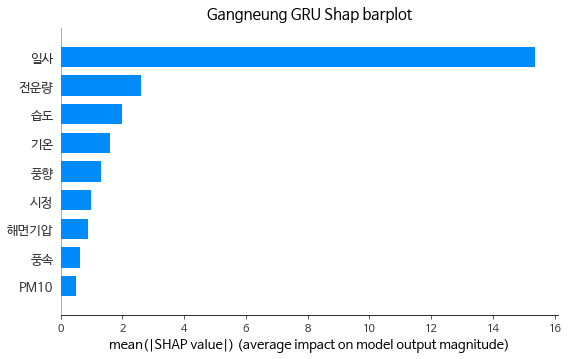

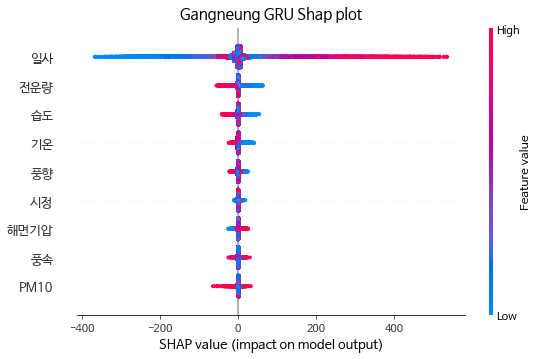

In [ ]:
ShapPlot(model_GRU, train_X, 'GRU', 'Gangneung', feature_ori)

# Save

In [ ]:
R2

[('Dev_LSTM_Mp', 0.8522194443569446),
 ('Dev_GRU_Mp', 0.8521294810126475),
 ('LSTM_Mp', 0.841238551375528),
 ('GRU_Mp', 0.8291781099590917),
 ('Dev_LSTM_Jj', 0.5532703121971712),
 ('Dev_GRU_Jj', 0.4830540416483),
 ('GRU_Jj', 0.40132978628911176),
 ('LSTM_Jj', 0.3777096211397787),
 ('Dev_LSTM_Gn', -0.4332770421237986),
 ('Dev_GRU_Gn', -0.4522919244056258),
 ('LSTM_Gn', -0.48980050099782924),
 ('GRU_Gn', -0.4986423880092177),
 {'GRU_Gn': -0.4142511526693582}]

In [ ]:
RMSE

[('Dev_LSTM_Jj', 47.783592847864576),
 ('Dev_GRU_Jj', 50.01466835312216),
 ('GRU_Jj', 54.52114681934776),
 ('LSTM_Jj', 54.84778804577712),
 ('Dev_LSTM_Mp', 145.45357280235564),
 ('Dev_GRU_Mp', 146.40225916177158),
 ('LSTM_Mp', 154.10493454225718),
 ('GRU_Mp', 157.158436340557),
 ('LSTM_Gn', 306.4987877145321),
 ('Dev_GRU_Gn', 307.96441904400615),
 ('Dev_LSTM_Gn', 308.0999901316328),
 ('GRU_Gn', 316.9087906820089),
 {'GRU_Gn': 313.1567045021667}]

In [ ]:
with open ('/content/gdrive/MyDrive/SolarPower/RMSE_score_RNN.pickle','wb') as fw:
  pickle.dump(RMSE, fw)
with open ('/content/gdrive/MyDrive/SolarPower/R2_score_RNN.pickle','wb') as fw:
  pickle.dump(R2, fw)  